Name: Rashmi Umalkar   

Question 1: Using the data, what factors impact clients choosing/selecting a tasker in the result page ? Feel free to build a predictive model to determine the factors that impact what tasker is being selected.


In [1]:
import pandas as pd
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import logit 
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns

#import datetime as dt
np.random.seed()

In [3]:
#Loading the data and looking at snapshot
analytics_data = pd.read_csv("Analytics_data.csv")
analytics_data.dtypes

funnel_search_id       object
created_at             object
tasker_id               int64
position                int64
hourly_rate             int64
num_completed_tasks     int64
hired                   int64
category               object
dtype: object

In [5]:
#Separating hired and not hired 
analytics_data_hired = analytics_data[analytics_data["hired"]== 1]
analytics_data_nothired = analytics_data[analytics_data["hired"]== 0]

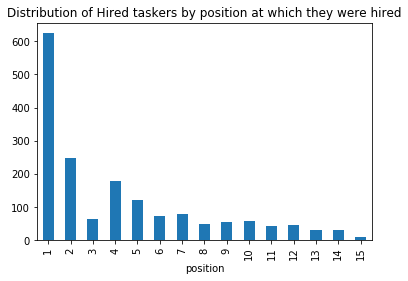

In [6]:
#Distribution of hired taskers by the position at which they got hired
analytics_data_hired.groupby("position")['tasker_id'].count().plot(kind="bar",title = 'Distribution of Hired taskers by position at which they were hired')

From the Distribution of hired taskers by position, can conclude that more than 50% (57%) taskers were hired at position 1 and hence positioning matters in a given recommendation set. The rest shows descent, showing higher the position in the recommendation, better are the chances of being hired.

To understand impact of number of tasks completed on being hired, binning the number of hours completed and analyzing tasker counts in eeach

In [7]:
#inserting column with the respective hours completed bin
nBins =20
completed_task_category = pd.cut(analytics_data.num_completed_tasks,bins=nBins)
analytics_data.insert(6,'completed task group',completed_task_category)
analytics_data.head()
#del analytics_data['completed task group']

,funnel_search_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,completed task group,hired,category
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1009185352,1,38,151,"(140.6, 210.9]",0,Furniture Assembly
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1006892359,2,40,193,"(140.6, 210.9]",0,Furniture Assembly
2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1012023956,3,28,0,"(-1.406, 70.3]",0,Furniture Assembly
3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1009733517,4,43,303,"(281.2, 351.5]",0,Furniture Assembly
4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,9/1/17 0:32,1013579273,5,29,39,"(-1.406, 70.3]",0,Furniture Assembly


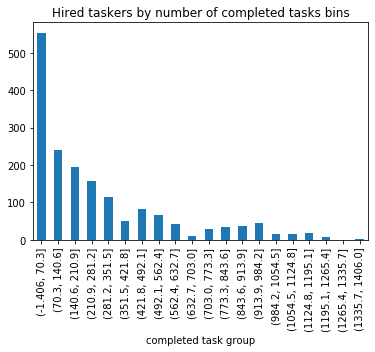

In [8]:
#separating hired and not hired after introducing the complted task group column
analytics_data_hired = analytics_data[analytics_data["hired"]== 1]
analytics_data_nothired = analytics_data[analytics_data["hired"]== 0]
#Plotting the Distribution of hired taskers by bins 
analytics_data_hired.groupby("completed task group")['tasker_id'].count().plot(kind="bar", title = 'Hired taskers by number of completed tasks bins')

For hired taskers, the distribution of taskers with prior experience or completed tasks seems to be maximum in group of 0-70. Other bins till 350 show gradual descent. The variable number of tasks completed seems to either not correrelated or negatively related to being hired.

We know mostly the taskers are hired at position 1 and number of tasks completed seems to have less impact when customers hire for taskers. Assuming the hiring preference would be for lower hourly rates. To Understand impact of hourly rate and number of tasks completed tasks, plotting hourly rate and completed tasks for hired taskers at position 1

[Text(0.5, 1.0, 'Taskers hired at position 1 - hourly rate and number of tasks completed')]

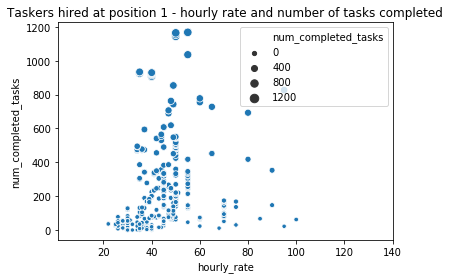

In [9]:
analytics_data_hired_positionone = analytics_data_hired[analytics_data_hired["position"] ==1]

ax= sns.scatterplot(x="hourly_rate", y="num_completed_tasks",
                     size = 'num_completed_tasks',
                     data= analytics_data_hired_positionone)
ax.set(xlim=(1, 140))
ax.set(title = 'Taskers hired at position 1 - hourly rate and number of tasks completed')

Seems the sweet spot for hourly rates is between 30 to 50 $ with preference for 0 to 600 tasks completed

[Text(0.5, 1.0, 'Hired taskers by positions and distribution of number of tasks they have completed')]

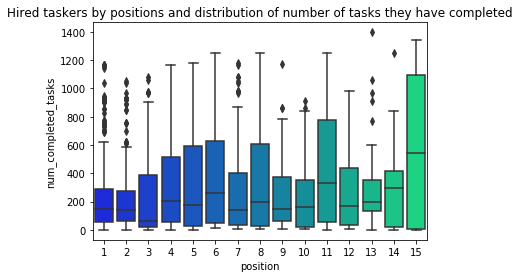

In [10]:
#Understanding median number of tasks completed by the position of tasker in recommendation set 
ax= sns.boxplot(x='position',y='num_completed_tasks',data=analytics_data_hired,palette='winter')
ax.set(title = 'Hired taskers by positions and distribution of number of tasks they have completed')

The median number of tasks completed for hired taskers at first five positions seem to be in 150-200. As the position increases(tasker hired when placed further bottom in the recommendation list). We can conclude that when taskers are hired after position 4 or 5, the customers hire them based on number of tasks completed. However the other reason can be lower hourly rates

In [11]:
#Adding a column number of taskers per recommendation set 
analytics_data_taskers_query = analytics_data.groupby('funnel_search_id')['tasker_id'].nunique().rename("num_taskers_per_query")
analytics_data = analytics_data.merge(analytics_data_taskers_query,on = 'funnel_search_id')

The probability of hired or not is a binary variable. To understand in depth the impact of variables on probability of being hired, Logistic regression can helpful. fitting initial regression model.

In [12]:
#Splitting the data into training and test sets
train, test = train_test_split(analytics_data, test_size=0.3, random_state = 1234)

In [13]:
#Fitting basic regression model on training set.
#Here our target variable is hired and other independent variables (as observed from earlier exploratory analysis) are 
#position, hourly rate, number of completed tasks, category, number of taskers per recommendation set
model = logit("hired ~ hourly_rate + position +category  + num_completed_tasks + num_taskers_per_query", data=train)
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.190598
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  hired   No. Observations:                21000
Model:                          Logit   Df Residuals:                    20993
Method:                           MLE   Df Model:                            6
Date:                Mon, 06 Jul 2020   Pseudo R-squ.:                  0.1277
Time:                        17:37:01   Log-Likelihood:                -4002.6
converged:                       True   LL-Null:                       -4588.5
Covariance Type:            nonrobust   LLR p-value:                6.026e-250
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0774      0.231      0.335      0.738      -0.376   

As we see, the initial regression, hourly rate, position, number of completed tasks and number of taskers per query show significant impact with lower pvalues. However category show higher pvalues. so removing category and fitting the model again gives us below summary

In [14]:
#Removing category as variable and running the model again
model = logit("hired ~ hourly_rate + position  + num_completed_tasks + num_taskers_per_query", data=train)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.190698
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  hired   No. Observations:                21000
Model:                          Logit   Df Residuals:                    20995
Method:                           MLE   Df Model:                            4
Date:                Mon, 06 Jul 2020   Pseudo R-squ.:                  0.1272
Time:                        17:37:04   Log-Likelihood:                -4004.7
converged:                       True   LL-Null:                       -4588.5
Covariance Type:            nonrobust   LLR p-value:                1.671e-251
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0172      0.228      0.075      0.940      -0.429       0.

R square is low showing poor model fit. R squared decreased as we removed category so we should be adding category back to the model

Hourly rate seems to be negatively correlated, the probability of being hired is higher for lower hourly rates. The position variable (ordinal) also seem to have negative coefficient,  lower the position, higher is the probabily of being hired.

In [15]:
#fitting the data on test set to predict the probability of being hired for test data
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# Compute prediction
prediction = result.predict(exog = test)



# Define the cutoff
cutoff = 0.3

# Compute class predictions: y_prediction
y_prediction = np.where(prediction > cutoff, 1, 0)

# Assign actual class labels from the test sample to y_actual
y_actual = test["hired"]


# Compute and print confusion matrix using crosstab function
conf_matrix = pd.crosstab(y_actual, y_prediction,
                       rownames = ["Actual"], 
                       colnames = ["Predicted"])
#, 
                     #  margins = True)
                      
# Print the confusion matrix
print(conf_matrix)

Predicted     0   1
Actual             
0          8462  29
1           487  22


The confusion matrix show very less 1's predicted. Also FP's are higher than correctly predicting 1's

In [16]:
#Checking model accuracy
accuracy = accuracy_score(y_actual, y_prediction)
print('Accuracy: %.2f' % accuracy + "%")

Accuracy: 0.94%


In [17]:
print(classification_report(y_actual, y_prediction))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8491
           1       0.43      0.04      0.08       509

    accuracy                           0.94      9000
   macro avg       0.69      0.52      0.52      9000
weighted avg       0.92      0.94      0.92      9000



In [18]:
#checking AUC
roc_auc = roc_auc_score(y_actual, y_prediction)
print('AUC: %.2f' % roc_auc + "%")

AUC: 0.52%


model shows higher accuracy of 94%, poor R squared and poor AUC of 52%
The model needs improvement, checking for hire probability 

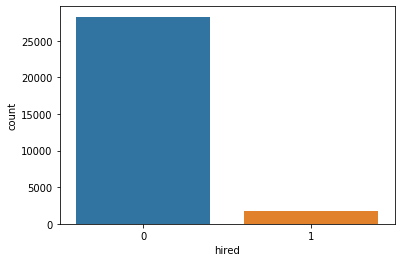

In [19]:
#TO understand the class distribution
sns.countplot(x='hired',data=analytics_data)

The countplot shows very less 1's compared to 0's as hired probability. This can be a case of class imbalance problem. It can be resolved either by oversampling minority class or by SMOTE

USING OVERSAMPLING MINORITY

In [20]:
feature_cols = ['position', 'hourly_rate', 'num_completed_tasks','category',  'num_taskers_per_query']
X = analytics_data[feature_cols] # Features
y = analytics_data.hired # Target variable

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=27)

In [22]:
X_concat = pd.concat([X_train, y_train], axis=1)
not_hired = X_concat[X_concat.hired==0]
hired_c = X_concat[X_concat.hired==1]

In [23]:
from sklearn.utils import resample
# upsample minority
hired_upsampled = resample(hired_c,
                          replace=True, # sample with replacement
                          n_samples=len(not_hired), # match number in majority class
                          random_state=27) # reproducible results

In [24]:
upsampled = pd.concat([not_hired, hired_upsampled])
upsampled.hired.value_counts()

1    16960
0    16960
Name: hired, dtype: int64

Now we have similar number of samples for 1's and 0's which can improve the model

In [25]:
y_train_upsampled = upsampled.hired
X_train_upsampled = upsampled.drop('hired', axis=1)
upsampled.head()

,position,hourly_rate,num_completed_tasks,category,num_taskers_per_query,hired
2191,3,95,625,Moving Help,15,0
5385,4,55,246,Mounting,15,0
29865,14,35,1,Furniture Assembly,15,0
16138,10,50,101,Mounting,15,0
28386,15,36,0,Mounting,15,0


In [26]:
model2 = logit("hired ~ hourly_rate + position +category + num_completed_tasks + num_taskers_per_query", data=upsampled)
result2 = model2.fit()
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.570811
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  hired   No. Observations:                33920
Model:                          Logit   Df Residuals:                    33913
Method:                           MLE   Df Model:                            6
Date:                Mon, 06 Jul 2020   Pseudo R-squ.:                  0.1765
Time:                        17:37:20   Log-Likelihood:                -19362.
converged:                       True   LL-Null:                       -23512.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.4566      0.110     22.382      0.000       2.242   